# Variational Autoencoder with MNIST and FashionMNIST

We will use Mnist and the Zalando FashionMNIST again, to train a variational autoencoder with will also be able to generate new cloth.

As a source for this notebook, see [https://blog.keras.io/building-autoencoders-in-keras.html]. A another accurate example can be found here: [https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776] .

To begin, we need to load some python modules including common layers from keras.

In [19]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
'''
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 10
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

print(input_train.shape)
print(input_test.shape)

tf.config.experimental_run_functions_eagerly(True)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


We prepare the data by normalizing it.

Since we are doing unsupervised learning here, we will not need the labels provided by the dataset for now. We keep them however, as they will help with visualizing the results later.

There are 60k training and 10k test examples.

In priciple, an autoencoder consists of two models: the encoder and the decoder. To represent this, we are using keras' functional API where we can easily define models from component models.

We start by defining the encoder, whose output will no be the latent vector, but the mean and log of the standard deviation of the latent representations.

In [20]:
# # =================
# # Encoder
# # =================

# Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

# Use reparameterization trick to ....??
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 14, 14, 8)    32          conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 7, 7, 16)     1168        batch_normalization_7[0][0]      
____________________________________________________________________________________________

The next submodel is on that sample from the distribution generated by the encoder.

Then we define the decoder, which takes the sampled latent vector as input and produces full-size images again.



In [21]:
# =================
# Decoder
# =================

# Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               2352      
_________________________________________________________________
batch_normalization_10 (Batc (None, 784)               3136      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 16)        2320      
_________________________________________________________________
batch_normalization_11 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 8)         1160

Finally, we concatenate everything to get our variational autoencoder.

In [22]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 17208     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         9137      
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


Now we define the loss function and compile everything!

In [23]:
# Define loss
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Total loss = 50% rec + 50% KL divergence loss
  return K.mean(reconstruction_loss + kl_loss)

# Compile VAE
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)


# Train the VAE




In [24]:
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 10s 207us/step - loss: 273.0396 - val_loss: 236.8839
Epoch 2/10
48000/48000 [==============================] - 7s 154us/step - loss: 173.3818 - val_loss: 166.2428
Epoch 3/10
48000/48000 [==============================] - 7s 153us/step - loss: 165.2973 - val_loss: 161.8486
Epoch 4/10
48000/48000 [==============================] - 7s 153us/step - loss: 162.1625 - val_loss: 159.3070
Epoch 5/10
48000/48000 [==============================] - 7s 155us/step - loss: 160.2830 - val_loss: 157.3688
Epoch 6/10
48000/48000 [==============================] - 7s 154us/step - loss: 159.1638 - val_loss: 156.1835
Epoch 7/10
48000/48000 [==============================] - 8s 159us/step - loss: 158.1769 - val_loss: 155.0860
Epoch 8/10
48000/48000 [==============================] - 7s 154us/step - loss: 157.3948 - val_loss: 155.1692
Epoch 9/10
48000/48000 [==============================] - 7s 155us/st

Now we define some visualisation functions to plot the latent.

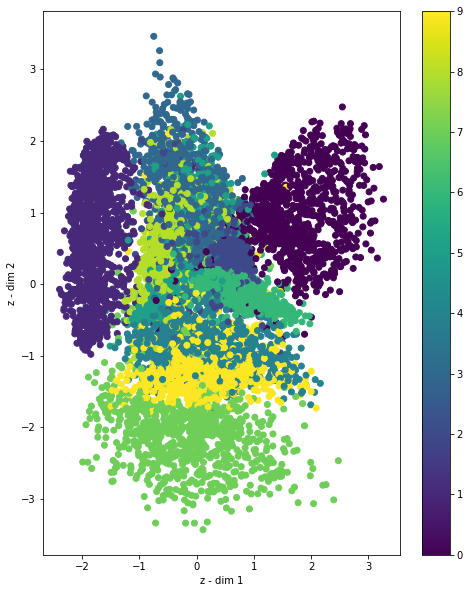

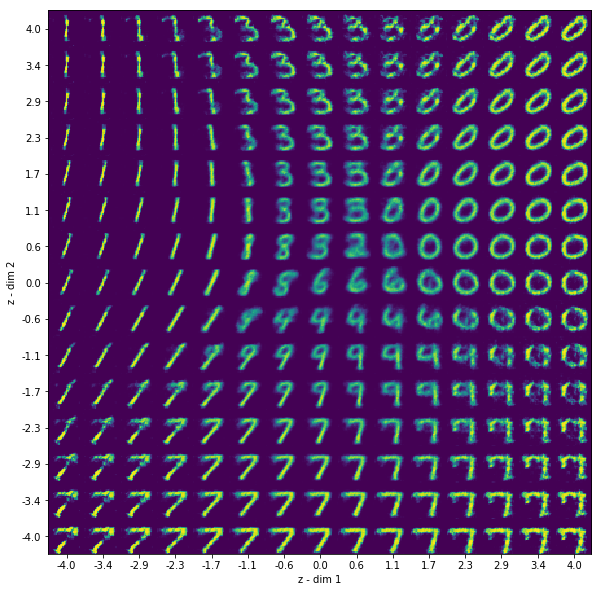

In [25]:
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

Here we define a function to compare original and reconstructed images, which we will use later.

In [26]:
def showImages(ae, data, n):
    decoded_imgs = ae.predict(data[:n])

      # how many cloth we will display
    height = 20
    plt.figure(figsize=(height, height/n*2))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [29]:
data[0]


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [32]:
showImages(vae, data[0][:,:,0],10)

ValueError: Error when checking input: expected encoder_input to have 4 dimensions, but got array with shape (10, 28, 1)

We can also sample the latent vectors, which should follow a unit gaussian to generate new data.

In [ ]:
def showImagesGen(decoder, sample=sample, n=20):
    latentDim = sample.inputs[0].shape.as_list()[-1]
    mean = np.array([0.]*latentDim*n).reshape([n,latentDim])
    stdev = np.array([1.]*latentDim*n).reshape([n,latentDim])
    decoded_imgs = decoder.predict(sample.predict([mean, stdev]))

    height = 20
    plt.figure(figsize=(height, height/n))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
showImagesGen(decoder)

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
!kill -9 $temp